## **RADI605: Modern Machine Learning**

### Assignment: Adaptive Boosting
**Romen Samuel Rodis Wabina** <br>
Student, PhD Data Science in Healthcare and Clinical Informatics <br>
Clinical Epidemiology and Biostatistics, Faculty of Medicine (Ramathibodi Hospital) <br>
Mahidol University

Note: In case of Python Markdown errors, you may access the assignment through this GitHub [Link](https://github.com/rrwabina/RADI605/blob/main/05%20Adaptive%20Boosting/scripts/assignment.ipynb)

### <code> Question 1-2. Please select one dataset from [UCI](https://archive.ics.uci.edu/ml/index.php). Describe the data characteristics by using appropriate statistical techniques. </code> 

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from numpy import mean
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA

import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from time import time
import random
import warnings
warnings.filterwarnings('ignore')

### Exploratory Data Analysis

We utilized the **Cervical Cancer Behaviour Risk Dataset** for this experiment. This dataset contains 19 attributes regarding cervical cancer with two (2) class labels, denoted as <code>ca_cervix</code>, with 1 and 0 as values - which means the respondent with and without cervical cancer, respectively. In addition,  the dependent variable <code>ca_cervix</code> is discrete and categorical in nature while its attributes are integers. 

In [2]:
data = pd.read_csv('../data/sobar-72.csv', sep = ',', header = 0)
print(f'The dataset contains {data.shape[0]} respondents with {data.shape[1]} attributes.')
data.head(10)

The dataset contains 72 respondents with 20 attributes.


,behavior_sexualRisk,behavior_eating,behavior_personalHygine,intention_aggregation,intention_commitment,attitude_consistency,attitude_spontaneity,norm_significantPerson,norm_fulfillment,perception_vulnerability,perception_severity,motivation_strength,motivation_willingness,socialSupport_emotionality,socialSupport_appreciation,socialSupport_instrumental,empowerment_knowledge,empowerment_abilities,empowerment_desires,ca_cervix
0,10,13,12,4,7,9,10,1,8,7,3,14,8,5,7,12,12,11,8,1
1,10,11,11,10,14,7,7,5,5,4,2,15,13,7,6,5,5,4,4,1
2,10,15,3,2,14,8,10,1,4,7,2,7,3,3,6,11,3,3,15,1
3,10,11,10,10,15,7,7,1,5,4,2,15,13,7,4,4,4,4,4,1
4,8,11,7,8,10,7,8,1,5,3,2,15,5,3,6,12,5,4,7,1
5,10,14,8,6,15,8,10,1,3,4,2,14,8,7,2,7,13,9,6,1
6,10,15,4,6,14,6,10,5,3,7,2,7,13,3,3,15,3,3,5,1
7,8,12,9,10,10,5,10,5,5,5,2,10,9,13,2,9,8,7,12,1
8,10,15,7,2,15,6,10,1,3,5,2,9,15,13,10,15,13,15,15,1
9,7,15,7,6,11,8,8,5,3,3,4,15,3,8,2,9,3,4,4,1


In [3]:
data.columns.values 

array(['behavior_sexualRisk', 'behavior_eating',
       'behavior_personalHygine', 'intention_aggregation',
       'intention_commitment', 'attitude_consistency',
       'attitude_spontaneity', 'norm_significantPerson',
       'norm_fulfillment', 'perception_vulnerability',
       'perception_severity', 'motivation_strength',
       'motivation_willingness', 'socialSupport_emotionality',
       'socialSupport_appreciation', 'socialSupport_instrumental',
       'empowerment_knowledge', 'empowerment_abilities',
       'empowerment_desires', 'ca_cervix'], dtype=object)

Lets now check if there are any missing values. Fortunately, there is no missing data. 

In [4]:
data.isnull().sum()

behavior_sexualRisk           0
behavior_eating               0
behavior_personalHygine       0
intention_aggregation         0
intention_commitment          0
attitude_consistency          0
attitude_spontaneity          0
norm_significantPerson        0
norm_fulfillment              0
perception_vulnerability      0
perception_severity           0
motivation_strength           0
motivation_willingness        0
socialSupport_emotionality    0
socialSupport_appreciation    0
socialSupport_instrumental    0
empowerment_knowledge         0
empowerment_abilities         0
empowerment_desires           0
ca_cervix                     0
dtype: int64

The table below shows the summary  statistics of the given data. It shows the central tendency and dispersion of every attribute. From this table, we calculated the row $cv$ that determines the coefficient of variation of every feature. Results have shown that the feature <code>perception_severity</code> indicates the largest variability in the data, relative to thhe mean. This suggests that this feature are spread out over a large range - indicating either high heterogeneity or a large amount of noise in the data. The <code>perception_severity</code>, having the largest variation, may indicate that the data may be difficult to interpret and not be representative of the underlying process. The feature <code>	behavior_sexualRisk</code> has the least variation among the independent variables.

In [13]:
describe = pd.DataFrame(data.describe())
mean, std = describe.iloc[1], describe.iloc[2]
describe.loc['cv'] = std / mean
describe

,behavior_sexualRisk,behavior_eating,behavior_personalHygine,intention_aggregation,intention_commitment,attitude_consistency,attitude_spontaneity,norm_significantPerson,norm_fulfillment,perception_vulnerability,perception_severity,motivation_strength,motivation_willingness,socialSupport_emotionality,socialSupport_appreciation,socialSupport_instrumental,empowerment_knowledge,empowerment_abilities,empowerment_desires,ca_cervix
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,9.666667,12.791667,11.083333,7.902778,13.347222,7.180556,8.611111,3.125000,8.486111,8.513889,5.388889,12.652778,9.694444,8.097222,6.166667,10.375000,10.541667,9.319444,10.277778,0.291667
std,1.186782,2.361293,3.033847,2.738148,2.374511,1.522844,1.515698,1.845722,4.907577,4.275686,3.400727,3.207209,4.130406,4.243171,2.897303,4.316485,4.366768,4.181874,4.482273,0.457719
min,2.000000,3.000000,3.000000,2.000000,6.000000,2.000000,4.000000,1.000000,3.000000,3.000000,2.000000,3.000000,3.000000,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000,0.000000
25%,10.000000,11.000000,9.000000,6.000000,11.000000,6.000000,8.000000,1.000000,3.000000,5.000000,2.000000,11.000000,7.000000,3.000000,3.750000,6.750000,7.000000,5.000000,6.750000,0.000000
50%,10.000000,13.000000,11.000000,10.000000,15.000000,7.000000,9.000000,3.000000,7.000000,8.000000,4.000000,14.000000,11.000000,9.000000,6.500000,12.000000,12.000000,10.000000,11.000000,0.000000
75%,10.000000,15.000000,14.000000,10.000000,15.000000,8.000000,10.000000,5.000000,14.000000,13.000000,9.000000,15.000000,13.000000,11.250000,9.000000,14.250000,15.000000,13.000000,15.000000,1.000000
max,10.000000,15.000000,15.000000,10.000000,15.000000,10.000000,10.000000,5.000000,15.000000,15.000000,10.000000,15.000000,15.000000,15.000000,10.000000,15.000000,15.000000,15.000000,15.000000,1.000000
cv,0.122771,0.184596,0.273731,0.346479,0.177903,0.212079,0.176017,0.590631,0.578307,0.502201,0.631063,0.253479,0.426059,0.524028,0.469833,0.416047,0.414239,0.448726,0.436113,1.569324


The given dataset contains values with integer data types and are not null.

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   behavior_sexualRisk         72 non-null     int64
 1   behavior_eating             72 non-null     int64
 2   behavior_personalHygine     72 non-null     int64
 3   intention_aggregation       72 non-null     int64
 4   intention_commitment        72 non-null     int64
 5   attitude_consistency        72 non-null     int64
 6   attitude_spontaneity        72 non-null     int64
 7   norm_significantPerson      72 non-null     int64
 8   norm_fulfillment            72 non-null     int64
 9   perception_vulnerability    72 non-null     int64
 10  perception_severity         72 non-null     int64
 11  motivation_strength         72 non-null     int64
 12  motivation_willingness      72 non-null     int64
 13  socialSupport_emotionality  72 non-null     int64
 14  socialSuppor

To find the correlation among the variables, we can make use of the correlation function <code>data.corr()</code>. This will give you a fair idea of the correlation strength between different variables. The figure below suggests the dataset's attributes is variedly correlated to other variables because there are attributes that are positively and negatively correlated to other variables. For instance, <code>empowerment_knowledge</code> is negatively correlated with <code>norm_fulfillment</code> with <code>r = -0.001287</code> while <code>perception_severity</code> is highly correlated with <code>norm_fulfillment</code> with <code>r = 0.853534</code>. This implies that variables with positive correlation exists when two variables operate in unison so that one variable rises or falls, the other does the same. A negative correlation is when two variable move oppositve one another so that when one variable rises, the other falls. These correlation results are important so that we can know how the change in one variable would impact the other parameter - especially when we feed the dataset to the machine learning model. 

<AxesSubplot:>

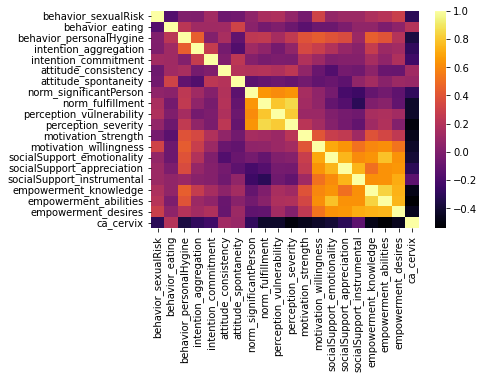

In [20]:
plt.figure(figsize=(6,4))
sns.heatmap(data.corr(), cmap = 'inferno', annot = False) 

Here, we make use of the Variance Inflation Factor to check the multicollinearity of data. To verify that multicollinearity does not exists; the <code>VIF</code> of every variable must not reach 10. If the <code>VIF</code> is equal to 1, there is no multicollinearity among factors, but if the <code>VIF</code> is greater than 1, the predictors may be highly correlated. A <code>VIF</code> between 5 and 10 indicates high correlation that may be problematic. If the <code>VIF</code> goes above 10, you can assume that the regression coefficients are poorly estimated due to multicollinearity. Statistically, and by theory, we should drop variables with high VIF. However,we care more about the predictions on how it affects the target variable due to the group of features rathen on each individual feature, then not removing multicollinearity may be a good option.

We can remove highly correlated variables or combine it into a single composite predictor if the first model simulation of the whole dataset will provide a poor model performance. If this happens, we can use **Principal Component Analysis** for dimensionality reduction. By transforming the original features into a new set of uncorrelated principal components, PCA can help to mitigate the effects of multicollinearity and reduce the VIF values in the data. This can improve the stability and interpretability of regression models, as well as reduce the risk of overfitting.

In [19]:
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
vif['Features'] = data.columns
vif.sort_values(by = 'VIF', ascending = False)

,VIF,Features
0,56.035416,behavior_sexualRisk
6,49.479450,attitude_spontaneity
16,49.279075,empowerment_knowledge
1,48.366256,behavior_eating
17,43.465168,empowerment_abilities
4,42.955054,intention_commitment
2,39.516902,behavior_personalHygine
5,36.515882,attitude_consistency
15,35.655084,socialSupport_instrumental
14,34.564197,socialSupport_appreciation


The boxplot for most features are comparatively tall, especially to <code>norm_significantPerson</code> and <code>norm_fulfillment</code>. These features suggests that respondents have varying degree (i.e., high variance) about this respective features. However, there are features whose boxplots are comparatively short. This suggests that the overall respondents have a high level of similarity (i.e., low variance) to this particular feature. This behaviour is primarily seen on <code>behaviour_sexualRisk</code> and <code>attitude_consistency</code>. 

Most features also consists outliers - suggesting that these features may not follow a normal distribution. This statistical feature can further be observed in the probability density plot later. 

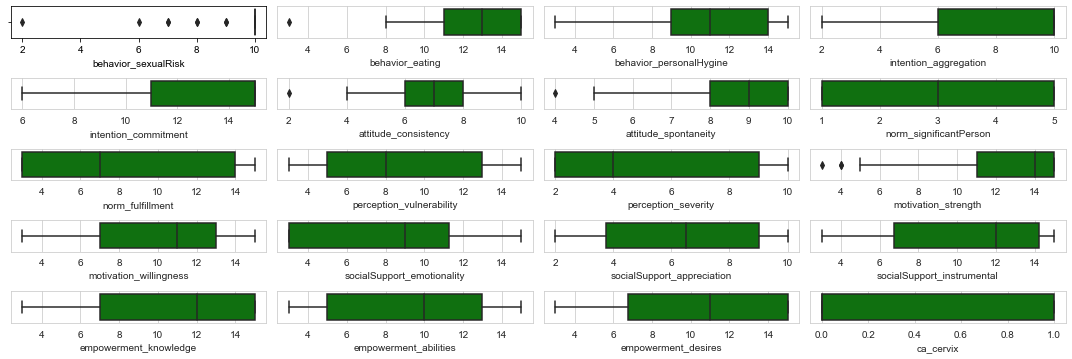

In [20]:
l = data.columns.values
number_of_columns = 4
number_of_rows = data.shape[0]
plt.figure(figsize = (15, 1 * number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1, number_of_columns, i+1)
    sns.set_style('whitegrid')
    sns.boxplot(data[l[i]], color = 'green', orient = 'v')
    plt.tight_layout()

All of the attributes from the cervical cancer dataset does not follow normality. 

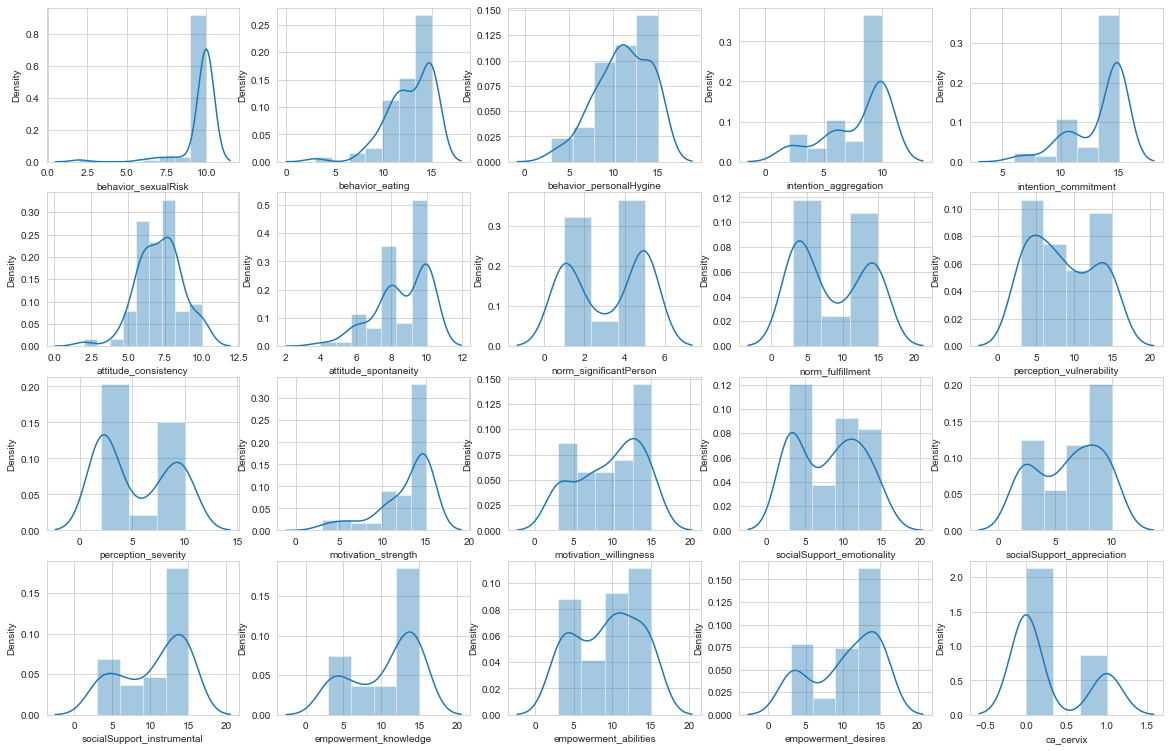

In [21]:
plt.figure(figsize = (20, 13))
for i in range(0,len(l)):
    plt.subplot(4, 5, i + 1)
    sns.set_style('whitegrid')
    sns.distplot(data[l[i]], kde = True) 

### Data Preprocessing

In [22]:
X = data.iloc[:, 0:19].to_numpy()
y = data.iloc[:, 19].to_numpy()
y[y == 0] = -1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

The barplot below shows the the cervical cancer dataset is imbalanced (i.e., distribution of the classes is unequal, with one or more classes being underrepresented.). This may lead to biased or unreliable results if the machine learning model is not trained to account for the imbalance in the data. One way to overcome this problem is to adopt resampling techniques to the training data. However, we can check the original dataset first if it can already provide good model performance on unseen dataset.

Text(0.5, 1.0, 'Imbalanced dataset')

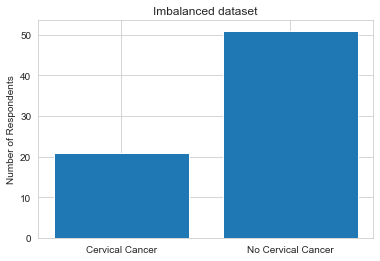

In [24]:
x = np.arange(2)
plt.bar(x, height = [len(y[y == 1]), len(y[y == -1])])
plt.xticks(x, ['Cervical Cancer', 'No Cervical Cancer'])
plt.ylabel('Number of Respondents')
plt.title('Imbalanced dataset')

### <code> Question 3. Create an adaptive boosting classifier with decision tree and SVM by using a python sklearn package. </code>

In [25]:
def train_adaboost(model):
    start = time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    class_names = ['Cervical Cancer', 'Healthy']
    
    confusion = confusion_matrix(y_test, y_pred)
    
    print("Adaptive Boosting score: ", np.round(accuracy_score(y_test, y_pred), 3))
    print('Confusion Matrix : \n', confusion)
    
    print(classification_report(y_test, y_pred, target_names = class_names))
    print(f"\t Fit and predict time: {np.round(time() - start, 3)} seconds")

### Experiment: SVM-based AdaBoost + GridSearchCV

In [26]:
def init_params():
    tuned_parameters = [{   'kernel': ['rbf'],
                            'gamma': [1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-7], 
                            'C': [0.001, 0.10, 0.1, 10, 20, 25, 50, 100, 1000]},

                        {   'kernel': ['sigmoid'], 
                            'gamma': [1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-7], 
                            'C': [0.001, 0.10, 0.1, 10, 20, 25, 50, 100, 1000]},

                        {   'kernel': ['linear'], 
                            'C': [0.001, 0.10, 0.1, 10, 20, 25, 50, 100, 1000]}]

    scoring = {'Precision': 'precision', 
               'Recall': 'recall', 
               'Accuracy': 'accuracy', 
               'AUC': 'roc_auc', 'F1': 'f1_micro'}

    return tuned_parameters, scoring

def get_svmtuning(X_train, y_train, cv = 10):
    tuned_parameters, scoring = init_params()
    random.seed(413)
    for name, score in zip(scoring.keys(), scoring.values()):
        clf = GridSearchCV(SVC(C = 1000), param_grid = tuned_parameters, cv = cv,
                            scoring = score, refit = 'Accuracy',
                            return_train_score = True)
        clf.fit(X_train, y_train)
        results = clf.cv_results_
        print(f'Best parameter set found on development set for {name}: \t {clf.best_params_}')
        return clf

get_svmtuning(X_train, y_train, cv = 10)
clf = SVC(kernel = 'rbf', C = 1210, gamma = 0.001)
adaboost_svm = AdaBoostClassifier(clf, algorithm = 'SAMME', n_estimators = 10, random_state = 0, learning_rate = 0.01)
train_adaboost(adaboost_svm)

Best parameter set found on development set for Precision: 	 {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Adaptive Boosting score:  1.0
Confusion Matrix : 
 [[14  0]
 [ 0  8]]
                 precision    recall  f1-score   support

Cervical Cancer       1.00      1.00      1.00        14
        Healthy       1.00      1.00      1.00         8

       accuracy                           1.00        22
      macro avg       1.00      1.00      1.00        22
   weighted avg       1.00      1.00      1.00        22

	 Fit and predict time: 0.024 seconds


### Experiment: Decision Tree-based AdaBoost + GridSearchCV

In [27]:
param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha'   : np.arange(0.001, 0.1, 0.01),
              'max_depth'   : np.arange(1, 15),
              'criterion'   : ['gini', 'entropy']}

tree_class = DecisionTreeClassifier(max_depth = 5, random_state = 1024)
grid_search = GridSearchCV(estimator = tree_class, param_grid = param_grid, cv = 5, verbose = True)
grid_search.fit(X_train, y_train)

adaboost_dct = AdaBoostClassifier(grid_search.best_estimator_, n_estimators = 3000, random_state = 0, learning_rate = 0.001)
train_adaboost(adaboost_dct)

Fitting 5 folds for each of 840 candidates, totalling 4200 fits
Adaptive Boosting score:  0.864
Confusion Matrix : 
 [[14  0]
 [ 3  5]]
                 precision    recall  f1-score   support

Cervical Cancer       0.82      1.00      0.90        14
        Healthy       1.00      0.62      0.77         8

       accuracy                           0.86        22
      macro avg       0.91      0.81      0.84        22
   weighted avg       0.89      0.86      0.85        22

	 Fit and predict time: 5.918 seconds


The SVM and Decision Trees were used as weak classifiers for the Adaptive Boosting siimulation. Results have shown that SVM as a weak classifier has better performance than Decision Trees. We utilized <code>F1-score</code> as the primary performance measurement since the classes showed an imbalanced dataset. The Decision Tree-based AdaBoost produced an <code>F1-score</code> of $0.90$ and $0.77$ for cervical cancer and non-cervical patients, respectively. On the other hand, SVM-based AdaBoost prodduced a perfect <code>F1-score</code> for both classes - suggesting that SVM-AdaBoost is able to classify the testing set perfectly. 

**Our results follow the same conclusion from different studies.** Existing research have shown that SVM-based AdaBoost obtains the best classification against Decision Tree-AdaBoost. <code>Barstugan and Ceylan (2014)</code> used different biomedical benchmark datasets, such as Wisconsin Breast Cancern, Pima Diabetes, and Liver Disorders (all taken from UCI website), to simulate on SVM-AdaBoost and DT-AdaBoost. For all experiments, training and testing time of Decision Tree-AdaBoost using the three datasets is shorter than SVM-AdaBoost. However, SVM-Adaboost has higher performance than Decision Tree-AdaBoost. 

**In theory, SVM is a strong classifier. It may not be well suited as a weak classifier for AdaBoost and may not seem to offer significant advantages in terms of generalization error.** However, past studies <code>(Wickramaratna et al., 2001)</code> have used SVM as the base classifier of Adaboost and have reported that the classification performance of the classifier decreases as the number of rounds increases. Our simulation may suggests that the size of the weights assigned by Adaboost to the weak SVMs, serve as an indication of which data points are likely to become support vectors in the final model, and hence can be useful in the implementation of editing algorithms. These may be the reasons why SVM performs better compared to Decision Trees as AdaBoost's weak classifier. Nonetheless, the SVM may still be a good choice for complex, non-linear problems, as it tries to find the hyperplane that separates the data using nonlinear kernels. Hence, a weakened version of SVM can still be useful as a base classifier. However, using SVM as a weak classifier in AdaBoost may not always lead to the best performance, and the choice of weak classifier will depend on the specific problem and data. 

**In general, it's a trade-off between accuracy, complexity, and interpretability, and the best option should be chosen based on the requirements of the problem.**


### Experiment: Decision Tree-based AdaBoost + GridSearchCV + Principal Component Analysis

While the dataset only consists of 19 attributes, high dimensionality can still be a problem for Decision Tree-based AdaBoost as weak classifiers due to the nature of decision trees. These tree-based models suffer from curse of dimensionality where the size of the tree can become large and unwieldy, leading to overfitting. To address this problem, we use dimensionality reduction techniques such as Principal Component Analysis to reduce the number of features before using AdaBoost with decision trees. We hypothesize that using PCA as a dimensionality reduction to the dataset can improve model performance to Decision Tree-based AdaBoost. 

In [15]:
X = data.iloc[:, 0:19].to_numpy()
y = data.iloc[:, 19].to_numpy()
y[y == 0] = -1

pca = PCA(n_components = 7)
X = pca.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha'   : np.arange(0.001, 0.1, 0.01),
              'max_depth'   : np.arange(1, 15),
              'criterion'   : ['gini', 'entropy']}

tree_class = DecisionTreeClassifier(max_depth = 5, random_state = 1024)
grid_search = GridSearchCV(estimator = tree_class, param_grid = param_grid, cv = 5, verbose = True)
grid_search.fit(X_train, y_train)

adaboost_dct = AdaBoostClassifier(grid_search.best_estimator_, n_estimators = 3000, random_state = 0, learning_rate = 0.001)
train_adaboost(adaboost_dct)

Fitting 5 folds for each of 840 candidates, totalling 4200 fits
Adaptive Boosting score:  0.955
Confusion Matrix : 
 [[14  0]
 [ 1  7]]
                 precision    recall  f1-score   support

Cervical Cancer       0.93      1.00      0.97        14
        Healthy       1.00      0.88      0.93         8

       accuracy                           0.95        22
      macro avg       0.97      0.94      0.95        22
   weighted avg       0.96      0.95      0.95        22

	 Fit and predict time: 1.685 seconds


Results above have shown that dimensionality reduction through Principal Component Analysis can improve Decision Tree-based AdaBoost model performance. The first simulation on Decision Tree-SVM shows a poorer performance because the features from the original dataset are highly correlated with one another - as indicated by their Variance Inflation Factor. By transforming the original features into a new set of uncorrelated principal components, PCA can help to mitigate the effects of multicollinearity and reduce the VIF values in the data. This can improve the stability and interpretability of regression models, as well as reduce the risk of overfitting.

### Reference:
[1] Barstuğan, M., & Ceylan, R. (2014). Comparison of Decision Tree and SVM Based AdaBoost Algorithms on Biomedical Benchmark Datasets. In MBEC2014: 6th European Conference of the International Federation for Medical and Biological Engineering (Vol. 63).
```
@inproceedings{barstuugan2014comparison,
  title={Comparison of Decision Tree and SVM Based AdaBoost Algorithms on Biomedical Benchmark Datasets},
  author={Barstu{\u{g}}an, M and Ceylan, R},
  booktitle={MBEC2014: 6th European Conference of the International Federation for Medical and Biological Engineering},
  volume={63},
  year={2014}
}
```

[2] Wickramaratna, J., Holden, S., Buxton, B.: Performance degradation in boosting. In Kittler, J., Roli, F., eds.: Proceedings of the 2nd International Workshop on Multiple Classifier Systems MCS2001. Volume 2096 of LNCS. Springer (2001) 11–21
```
@inproceedings{wickramaratna2001performance,
  title={Performance degradation in boosting},
  author={Wickramaratna, Jeevani and Holden, Sean and Buxton, Bernard},
  booktitle={Multiple Classifier Systems: Second International Workshop, MCS 2001 Cambridge, UK, July 2--4, 2001 Proceedings 2},
  pages={11--21},
  year={2001},
  organization={Springer}
}
```